<a href="https://colab.research.google.com/github/soumitrahazra/My_Data_Analysis_Codes/blob/main/Different_CME_Property_Analysis_from_LASCO_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This is the code for the calculation of different CME properties (kinematical and morphological) from LASCO image.

This code is developed by Soumitra Hazra

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import glob
import cv2
from sunpy.net import Fido, attrs as a
from datetime import datetime, timedelta
import os
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [57]:
# === Step 1: Create base output folder ===
base_dir = "/content/lasco_data"
os.makedirs(base_dir, exist_ok=True)

In [58]:
# === Set Time Range and Instrument ===
start_time = "2023-11-01 00:00"
end_time = "2023-11-01 3:00"  # adjust as needed

# Query for LASCO C2 images (change to C3 if needed)
result = Fido.search(
    a.Time(start_time, end_time),
    a.Instrument.lasco,
    a.Detector("C2"),  # or "C3"
    a.Physobs.intensity
)

# Print result summary
print(result)

Results from 1 Provider:

15 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Data retrieval status: https://docs.virtualsolar.org/wiki/VSOHealthReport
Total estimated size: 29.529 Mbyte

       Start Time               End Time        Source Instrument Provider  Physobs  Extent Type   Size 
                                                                                                  Mibyte
----------------------- ----------------------- ------ ---------- -------- --------- ----------- -------
2023-11-01 00:00:05.000 2023-11-01 00:00:30.000   SOHO      LASCO     SDAC intensity      CORONA 2.01074
2023-11-01 00:12:05.000 2023-11-01 00:12:30.000   SOHO      LASCO     SDAC intensity      CORONA 2.01074
2023-11-01 00:24:05.000 2023-11-01 00:24:30.000   SOHO      LASCO     SDAC intensity      CORONA 2.01074
2023-11-01 00:36:07.000 2023-11-01 00:36:32.000   SOHO      LASCO     SDAC intensity      CORONA 2.01074
2023-11-01 00:48:05.000 2023-11-01 00:48:30.000  

In [59]:
def fetch_cme_events_from_txt(min_speed=500, min_width=60, start_date=None, end_date=None):
    # URL for the univ_all.txt catalog
    url = "https://cdaw.gsfc.nasa.gov/CME_list/UNIVERSAL/text_ver/univ_all.txt"

    # Download the catalog file
    response = requests.get(url)
    response.raise_for_status()  # Will raise an error if the download fails

    # Parse the file line-by-line
    lines = response.text.splitlines()

    # Filter the lines for relevant data (skip header lines)
    events = []
    for line in lines[10:]:  # Skipping header lines
        if len(line.strip()) == 0:
            continue  # Skip empty lines

        # Split by space (or multiple spaces) to capture columns
        cols = [col.strip() for col in line.split() if col.strip()]

        if len(cols) < 10:  # Skip malformed lines
            continue

        try:
            # Date and time extraction
            date_str = cols[0] + " " + cols[1]  # e.g., 2023/01/01 01:00:00
            event_time = datetime.strptime(date_str, "%Y/%m/%d %H:%M:%S")

            # Extract width, speed, and event data
            width = int(cols[6])
            speed = int(cols[7])

            if speed >= min_speed and width >= min_width:
                # If within speed and width limits, add to events
                if start_date and event_time < pd.to_datetime(start_date):
                    continue
                if end_date and event_time > pd.to_datetime(end_date):
                    continue

                events.append({
                    "time": event_time,
                    "width": width,
                    "speed": speed
                })
        except Exception as e:
            # Handle errors (e.g., value parsing errors)
            continue

    return events

In [60]:
# === Step 3: Download LASCO data ===
def download_lasco_images(events, instrument="C2", margin_min=60):
    # If a single event is passed, wrap it in a list
    if isinstance(events, dict):
        events = [events]
    elif isinstance(events, str):
        events = [{"time": datetime.strptime(events, "%Y-%m-%d %H:%M")}]

    for event in events:
        t0 = event["time"]
        t_start = (t0 - timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")
        t_end = (t0 + timedelta(minutes=margin_min)).strftime("%Y-%m-%d %H:%M")

        subdir = f"{t0.strftime('%Y-%m-%dT%H-%M')}_{instrument}"
        output_path = os.path.join(base_dir, subdir)
        os.makedirs(output_path, exist_ok=True)

        print(f"\n CME at {t0} | Speed: {event['speed']} km/s | Width: {event['width']}°")
        print(f"   Saving to: {output_path}")

        try:
            result = Fido.search(
                a.Time(t_start, t_end),
                a.Instrument.lasco,
                a.Detector(instrument),
                a.Physobs.intensity
            )

            if result.file_num > 0:
                files = Fido.fetch(result, path=os.path.join(output_path, "{file}"))
                print(f" Downloaded {len(files)} images.")
            else:
                print("⚠️ No data found.")
        except Exception as e:
            print(f"❌ Download error: {e}")


In [61]:
# Example usage
events = fetch_cme_events_from_txt(
    min_speed=600,
    min_width=100,
    start_date="2023-01-01",
    end_date="2023-03-31"
)


In [62]:
print(f"Found {len(events)} CME events.")
for event in events[:5]:
    print(event)

Found 186 CME events.
{'time': datetime.datetime(2023, 1, 2, 18, 36, 5), 'width': 734, 'speed': 1072}
{'time': datetime.datetime(2023, 1, 3, 6, 36, 5), 'width': 910, 'speed': 1051}
{'time': datetime.datetime(2023, 1, 3, 11, 36, 5), 'width': 348, 'speed': 649}
{'time': datetime.datetime(2023, 1, 3, 14, 12, 5), 'width': 712, 'speed': 703}
{'time': datetime.datetime(2023, 1, 4, 9, 12, 9), 'width': 486, 'speed': 824}


In [63]:
selected_cme_event=events[0]
print(selected_cme_event)

{'time': datetime.datetime(2023, 1, 2, 18, 36, 5), 'width': 734, 'speed': 1072}


In [64]:
download_lasco_images(selected_cme_event, instrument="C2", margin_min=60)


 CME at 2023-01-02 18:36:05 | Speed: 1072 km/s | Width: 734°
   Saving to: /content/lasco_data/2023-01-02T18-36_C2


Files Downloaded:   0%|          | 0/7 [00:00<?, ?file/s]

 Downloaded 7 images.


In [65]:
!pip install ffmpeg-python --quiet

In [66]:
import os
import glob
from astropy.io import fits
import matplotlib.pyplot as plt

fits_dir = "/content/lasco_data/2023-01-02T18-36_C2/"
output_img_dir = "/content/lasco_frames"
os.makedirs(output_img_dir, exist_ok=True)

fits_files = sorted(glob.glob(os.path.join(fits_dir, "*.fts")))

for i, file_path in enumerate(fits_files):
    with fits.open(file_path) as hdul:
        data = hdul[0].data

    # Optional: normalize for better contrast
    norm_data = (data - data.min()) / (data.max() - data.min())

    # Save frame as image
    frame_path = os.path.join(output_img_dir, f"frame_{i:03d}.jpg")
    plt.imsave(frame_path, norm_data, cmap='gray')


In [67]:
import ffmpeg

output_gif = "/content/cme_event.gif"

(
    ffmpeg
    .input('/content/lasco_frames/frame_%03d.jpg', framerate=1)
    .output(output_gif, vf='scale=800:-1', loop=0)
    .run(overwrite_output=True)
)

print(f"✅ GIF saved at {output_gif}")

✅ GIF saved at /content/cme_event.gif


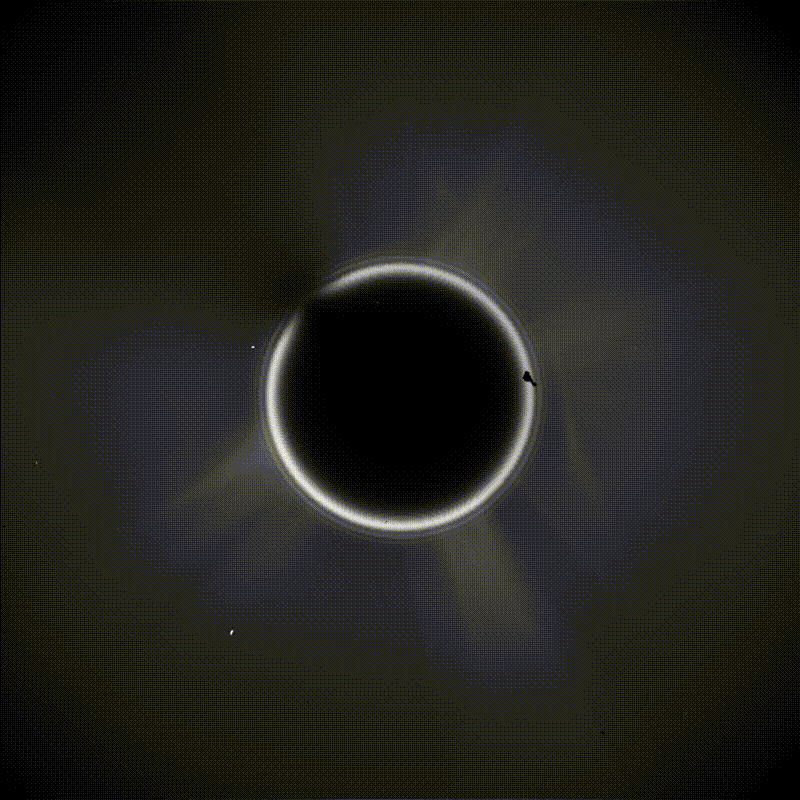

In [68]:
from IPython.display import Image
Image(filename=output_gif)